In [1]:
#Essentials library
import pandas as pd
import numpy as np
from numpy import array

#Library untuk modeling
import tensorflow
from tensorflow import keras
from keras import layers, models, Input
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from keras.metrics import Accuracy, Recall, Precision
from keras.callbacks import EarlyStopping

#Library untuk evaluasi
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

#Library untuk preprocessing
!pip install nltk
import nltk
nltk.download('punkt')
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory 
from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec

#Miscellaneous library
import re
import string
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 7.3 MB/s eta 0:00:00


In [2]:
#Method untuk subtitusi slang
def array_contains(word, array):
  return word in array

def remove_slang(text):
  words = text.split()
  new_text = []
  
  for word in words:
    if word.lower() in slang_dict:
      new_text.append(slang_dict[word.lower()])
    else:
      new_text.append(word)
  
  return " ".join(new_text)

#Method untuk hapus stopword manual
def remove_stopwords(text):
  words = text.split(' ')
  stopped_words = [word for word in words if not array_contains(word, stopwords)]

  return ' '.join(stopped_words)

#Method untuk tokenize kalimat dari dataframe
def tokenize_dataframe(dataframe, column):
  all_sentences = []
  for index, row in dataframe.iterrows():
    all_sentences.append(row[column])
 
  all_token = []
 
  #Iterasi kalimat dalam dataframe
  for sentence in all_sentences:
    for i in sent_tokenize(sentence):
      token = []
     
      #Tokenisasi kalimat jadi kata
      for j in word_tokenize(i):
          token.append(j.lower())
 
      all_token.append(token)

  return all_token

#Method buat vektor kalimat dari Word2Vec
def sentence_vectorize(model, data):
  all_vector = []

  for sentence in data:
    s_vector = []
    for token in sentence.split():
      if token in model.wv:
        token_vector = model.wv[token]
        s_vector.append(token_vector)
      else:
        s_vector.append(np.zeros(100, dtype=np.float32))
    all_vector.append(s_vector)

  return all_vector

In [ ]:
#Baca CSV
df_anger = pd.read_csv('AngerData.csv', sep='\t')
df_fear = pd.read_csv('FearData.csv', sep='\t')
df_joy = pd.read_csv('JoyData.csv', sep='\t')
df_love = pd.read_csv('LoveData.csv', sep='\t')
df_neutral = pd.read_csv('NeutralData.csv', sep='\t')
df_sad = pd.read_csv('SadData.csv', sep='\t')

#Gabungkan CSV
df_all = pd.concat([df_anger, df_fear, df_joy, df_love, df_neutral, df_sad], ignore_index=True)

In [ ]:
#Buka korpus slang dari file txt
with open('combined_slang_words.txt') as word:
    slang = word.read()
slang_dict = json.loads(slang)

#Tambahan slang manual
#with open('custom_slang.txt') as word:
#    slang = word.read()
#custom_slang = json.loads(slang)

#Gabung 2 korpus
#slang_dict.update(custom_slang)

#Stopword dari NLP Resources
with open('combined_stop_words.txt') as word:
    stopwords = word.read()
stopwords = stopwords.split(sep = "\n")

In [ ]:
#Case Folding
df_all['Tweet'] = df_all['Tweet'].apply(lambda row : row.lower())

#Mengganti slang
df_all['Tweet'] = df_all['Tweet'].apply(lambda row : remove_slang(row))

#Hapus angka
df_all['Tweet'] = df_all['Tweet'].apply(lambda row : re.sub(r"\d+", "", row))

#Menghapus tanda baca
df_all['Tweet'] = df_all['Tweet'].apply(lambda row : row.translate(str.maketrans("","",string.punctuation)))

#Menghapus link
df_all['Tweet'] = df_all['Tweet'].apply(lambda row : re.sub(r"http\S+", "", row))

#Menghapus emot
regrex_pattern = re.compile(pattern = "["u"\U0001F600-\U0001F64F" # emoticons
                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
                            u"\U0001F680-\U0001F6FF" # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                            "]+", flags = re.UNICODE)
df_all['Tweet'] = df_all['Tweet'].apply(lambda row : regrex_pattern.sub(r"",row))

#Menghapus spasi doble
df_all['Tweet'] = df_all['Tweet'].apply(lambda row : row.strip())

#Menghapus stopword
df_all['Tweet'] = df_all['Tweet'].apply(lambda row : remove_stopwords(row))

#Menjadikan kata dasar
factory = StemmerFactory()
stemmer = factory.create_stemmer()

df_all['Tweet'] = df_all['Tweet'].apply(lambda row : stemmer.stem(row))

#Untuk simpan hasil preprocessing
df_all.to_csv('preped.csv', index = False)

In [17]:
#Import hasil preprocessing dari preped.csv
preped = pd.read_csv('preped.csv')

preped['Tweet'] = preped['Tweet'].astype(str)

#Split train dan test 
X_train, X_test, Y_train, Y_test = train_test_split(
    preped['Tweet'], preped['Label'], test_size = 0.2, random_state = 42)

#Maksimum kata yang digunakan
MAX_NB_WORDS = 500
#Maksimum kata tiap tweet
MAX_SEQUENCE_LENGTH = 20
#Panjang vektor embedding
EMBEDDING_DIM = 100

#Buat embedding dengan Keras Layer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(preped['Tweet'].values) #Fit tokenizier ke dataset

#Tokenizing dan padding di data training
token_train = tokenizer.texts_to_sequences(X_train)
pad_train = pad_sequences(token_train, maxlen=MAX_SEQUENCE_LENGTH)

#Tokenizing dan padding di data testing
token_test = tokenizer.texts_to_sequences(X_test)
pad_test = pad_sequences(token_test, maxlen=MAX_SEQUENCE_LENGTH)

#Buat embedding dengan Word2Vec
#all_words = tokenize_dataframe(preped, 'Tweet')
#w2v_model = Word2Vec(all_words, min_count = 1, vector_size = EMBEDDING_DIM, window = 5)

#Tokenizing dan padding di data training
#train_vec = sentence_vectorize(w2v_model, X_train.values)
#pad_train = pad_sequences(train_vec, maxlen=MAX_SEQUENCE_LENGTH)

#Tokenizing dan padding di data testing
#test_vec = sentence_vectorize(w2v_model, X_test.values)
#pad_test = pad_sequences(test_vec, maxlen=MAX_SEQUENCE_LENGTH)

#Ubah label jadi kategorikal
train_label = pd.get_dummies(Y_train.values)
test_label = pd.get_dummies(Y_test.values)

In [18]:
#Tweet input
input_tweets = Input(shape = (MAX_SEQUENCE_LENGTH, ), name='input_tweets')

#Tweet embedding layer
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = MAX_SEQUENCE_LENGTH, name='embedding_layer')
embedded_tweets = embedding_layer(input_tweets)

#LSTM Layer
lstm_layer0 = LSTM(EMBEDDING_DIM, return_sequences = True, dropout = 0.3,
                   name="lstm_layer")
lstm0 = lstm_layer0(embedded_tweets)

#Attention layer
attention_layer = MultiHeadAttention(num_heads = 2, key_dim = 2, dropout = 0.3, name='attention_layer')
attention_out, attention_weight = attention_layer(lstm0, lstm0, return_attention_scores=True)

#Output layer for Classification
output_layer = Dense(6,activation='softmax', name='output')
output = output_layer(attention_out)

#Output pooling
pooled_output = GlobalAveragePooling1D(name='output_pooling')(output)

#Buat model
training_model = models.Model(input_tweets, pooled_output, name='emotion_model')
training_model.summary()

training_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

pocket = EarlyStopping(monitor='val_accuracy', min_delta=0.001,
                       patience=10, verbose=1, mode='max',
                       restore_best_weights = True)

Model: "emotion_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tweets (InputLayer)      [(None, 20)]         0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 20, 100)      50000       ['input_tweets[0][0]']           
                                                                                                  
 lstm_layer (LSTM)              (None, 20, 100)      80400       ['embedding_layer[0][0]']        
                                                                                                  
 attention_layer (MultiHeadAtte  ((None, 20, 100),   1712        ['lstm_layer[0][0]',             
 ntion)                          (None, 2, 20, 20))               'lstm_layer[0][0]'] 

In [19]:
#Training model dengan dataset training
history = training_model.fit(x=pad_train, y=train_label, batch_size=50,
                             epochs=100, workers=3, use_multiprocessing=True, 
                             validation_split=0.2, shuffle=True, callbacks = [pocket])

Epoch 1/100
91/91 [==============================] - 15s 120ms/step - loss: 1.7409 - accuracy: 0.2812 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7190 - val_accuracy: 0.3010 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
91/91 [==============================] - 2s 26ms/step - loss: 1.6061 - accuracy: 0.3363 - precision: 0.6577 - recall: 0.0377 - val_loss: 1.5678 - val_accuracy: 0.3557 - val_precision: 0.6889 - val_recall: 0.0274
Epoch 3/100
91/91 [==============================] - 2s 24ms/step - loss: 1.4543 - accuracy: 0.4006 - precision: 0.6203 - recall: 0.0956 - val_loss: 1.4765 - val_accuracy: 0.4307 - val_precision: 0.6144 - val_recall: 0.0830
Epoch 4/100
91/91 [==============================] - 2s 19ms/step - loss: 1.2695 - accuracy: 0.5067 - precision: 0.6407 - recall: 0.1814 - val_loss: 1.2590 - val_accuracy: 0.5472 - val_precision: 0.6624 - val_recall: 0.4157
Epoch 5/100
91/91 [==============================] - 3s 28ms/step - loss: 1.0414 - acc

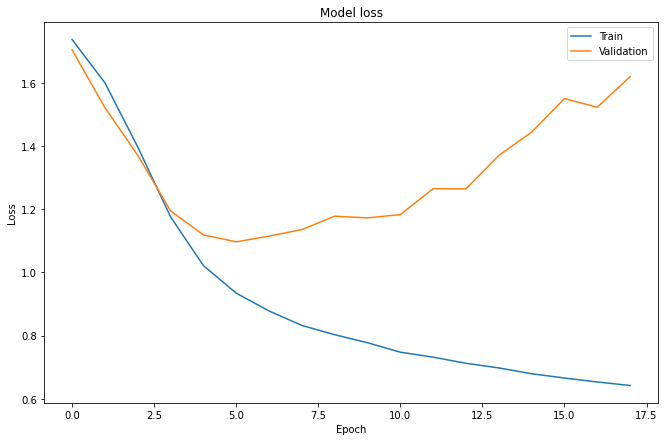

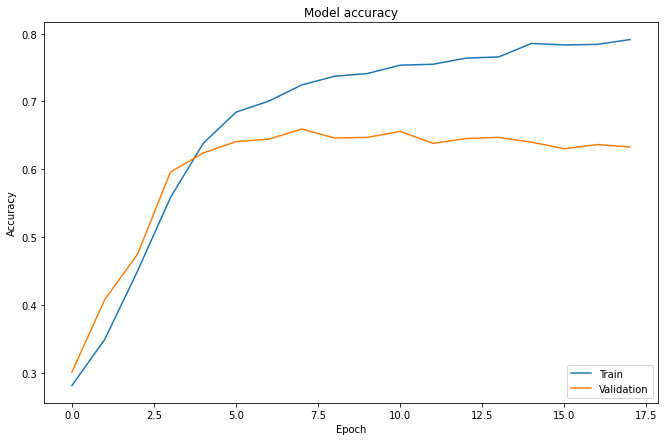

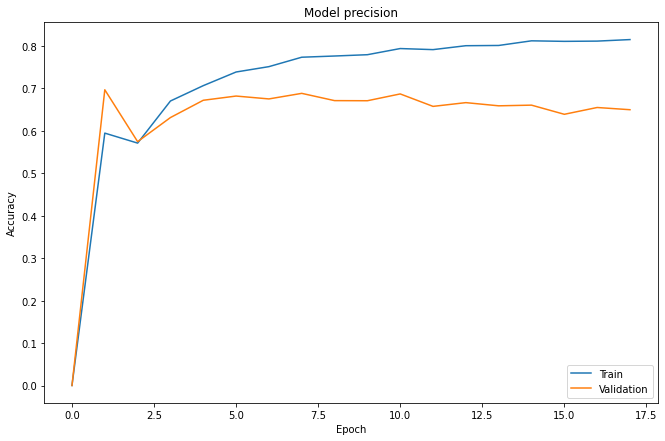

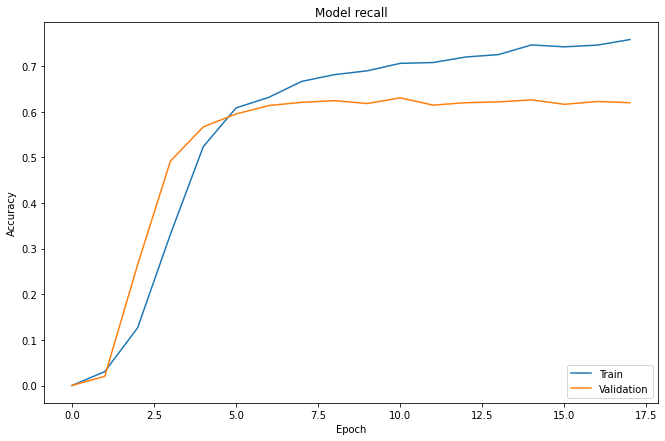

In [ ]:
#Plot metrics untuk training
figure(num=None, figsize=(11, 7))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

figure(num=None, figsize=(11, 7))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

figure(num=None, figsize=(11, 7))

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

figure(num=None, figsize=(11, 7))

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [20]:
#Evaluasi model
results = training_model.evaluate(x=pad_test, y=test_label,
                                  batch_size=200, verbose=1,
                                  workers=1, use_multiprocessing=False)

print('Test loss:', results[0])
print('Test accuracy:', results[1])
print('Test precision:', results[2])
print('Test recall:', results[3])

8/8 [==============================] - 0s 6ms/step - loss: 1.0469 - accuracy: 0.6660 - precision: 0.7037 - recall: 0.6222
Test loss: 1.046929121017456
Test accuracy: 0.665960431098938
Test precision: 0.7036741375923157
Test recall: 0.6221751570701599


In [ ]:
#Buat prediksi
pred = training_model.predict(x=pad_test)
CATEGORIES = np.array(['Anger', 'Fear', 'Joy', 'Love', 'Neutral', 'Sad'])
pred_named = CATEGORIES[np.argmax(pred, axis = 1)]

pred_acc = accuracy_score(Y_test.values, pred_named)
pred_precision, pred_recall, pred_f1score, pred_support = precision_recall_fscore_support(Y_test.values, pred_named, average='macro', labels=CATEGORIES)

print('Prediction accuracy:', pred_acc)
print('Prediction precision:', pred_precision)
print('Prediction recall:', pred_recall)
print('Prediction f1 score:', pred_f1score)

45/45 [==============================] - 1s 15ms/step
Prediction accuracy: 0.6716101694915254
Prediction precision: 0.6777607573267602
Prediction recall: 0.7012949838287911
Prediction f1 score: 0.6812637155569438


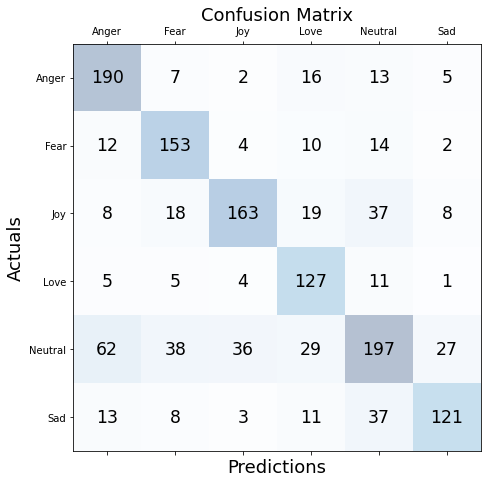

In [ ]:
#Confusion Matrix dari prediksi
conf_matrix = confusion_matrix(Y_test.values, pred_named, labels = CATEGORIES)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.xticks(ticks = [0, 1, 2, 3, 4, 5], labels = CATEGORIES)
plt.yticks(ticks = [0, 1, 2, 3, 4, 5], labels = CATEGORIES)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
#Ambil weight dari attention_layer untuk ekstraksi kontribusi kata
extractor = keras.Model(inputs=training_model.inputs,
                        outputs=[layer.output for layer in training_model.layers])
features = extractor(pad_test) #Inputkan dataset test
attention_weight = features[3][1] #Weight pada layer attention

Kalimat : i want to ask as bvyer klo kita dm minta pl dan over bvdget kita boleh ngabarin "maaf ya kak over bvdget" gitu gak sih? takut gak enak.. atau ada saran kalimat lain buat blsnya?
Real label : Fear, Predicted label : Fear


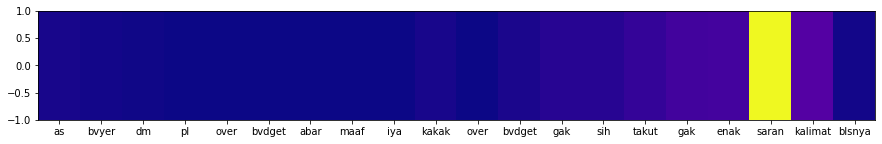

In [ ]:
#Pilih kalimat untuk dianalisa
index_kalimat = 254

#attention_layer terdiri dari 2 attention head dan tiap kata terdiri dari 100 vektor
#Maka weight perlu dirata-rata untuk mendapatkan satu nilai kontribusi untuk satu kata

#Jika data mentah diberi padding untuk memenuhi MAX_SEQUENCE_LENGTH
if len(X_test.values[index_kalimat].split()) < MAX_SEQUENCE_LENGTH: 
  kontribusi = np.mean(attention_weight[index_kalimat], axis = (0, 1))
  kontribusi = kontribusi[-len(X_test.values[index_kalimat].split()):]
  kata = X_test.values[index_kalimat].split()
#Jika data mentah dipotong untuk memenuhi MAX_SEQUENCE_LENGTH 
else: 
  kontribusi = np.mean(attention_weight[index_kalimat], axis = (0, 1))
  kata = X_test.values[index_kalimat].split()
  kata = kata[-MAX_SEQUENCE_LENGTH:]

print('Kalimat : {}'.format(df_all.iloc[X_test.index[index_kalimat]]['Tweet']))
print('Real label : {}, Predicted label : {}'.format(Y_test.values[index_kalimat], pred_named[index_kalimat]))

#Buat heatmap kontribusi kata
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
img = ax.imshow([kontribusi], cmap='plasma', aspect='auto', extent=[-1,1,-1,1])
ax.set_xticks([-1 + (i+0.5)*2/len(kata) for i in range(len(kata))])
ax.set_xticklabels(kata)
plt.show()